# Capstone Project - The Battle of the Neighborhoods
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

In this project we will try to find a optimal location for a restaurant. This report will be targeted to stakeholders interested in opening an **Japanese** restaurant in **São Paulo**, Brazil.

Since there are lots of restaurants in São Paulo, we will assume the hypothesis that crowded areas are the best locations for a restaurant, we will focus in areas near of subway stations.

With the aid of our data and data science skills, we will generate a few most promissing neighborhoods based on this criteria. We will make clear the advantages of each neighborhood so that best possible location can be chosen by stakeholders.

## Data <a name="data"></a>

Based on definition of our problem, factors that will influence our decision are:
* number of existing restaurants in the neighborhood (any type of restaurant)
* number of japanese restaurants in the neighborhood

Following data sources will be used to extract/generate the required information:
* number of restaurants and their type and location in every neighborhood will be obtained using **Foursquare API**
* coordinate of São Paulo center will be obtained using **Google Maps API geocoding**
* csv file with coordinates of metro stations obtained on **Kaggle.com**

## Methodology <a name="methodology"></a>

As the first step we will gather all the venues within 500 meters of each subway station.

Next we will analyze and build a DataFrame with the most common venues in each station's neighborhood and separete in types with Foursquare API.

In third and final step, we will clustering using the algorithm "K-Means" to separete the most commons venues in clusters. 

## Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json
from pandas.io.json import json_normalize
%matplotlib inline

## Dataframe of the metro stations of São Paulo

In [2]:
metros = pd.read_csv('metrosp_stations.csv')
metros.drop(['Unnamed: 0', 'station'], axis=1, inplace=True)
metros.head()

,name,lat,lon,line,neigh
0,Aacd Servidor,-23.597825,-46.652374,['lilas'],"['moema', 'hospital-sao-paulo']"
1,Adolfo Pinheiro,-23.650073,-46.704206,['lilas'],"['largo-treze', 'alto-da-boa-vista']"
2,Alto Da Boa Vista,-23.641625,-46.699434,['lilas'],"['adolfo-pinheiro', 'borba-gato']"
3,Alto Do Ipiranga,-23.602237,-46.612486,['verde'],"['santos-imigrantes', 'sacoma']"
4,Ana Rosa,-23.581871,-46.638104,"['azul', 'verde']","['paraiso', 'vila-mariana', 'paraiso', 'chacar..."


## Create a map São Paulo's metro stations with Folium

In [3]:
import folium

In [4]:
latitude = -23.5489 
longitude = -46.6388

In [5]:
map_sp = folium.Map(location=[latitude, longitude], zoom_start=10)
for lat, lon, name, line, neigh in zip(metros['lat'], metros['lon'], metros['name'], metros['line'], metros['neigh']):
    label = '{}, {}, {}'.format(name, line, neigh)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker([lat, lon], radius=5, popup=label, color='blue', fill=True, fill_color='#3186cc', fill_opacity=0.7, parse_html=False).add_to(map_sp)
    
    
map_sp        

## Exploring with Foursquare API

In [6]:
CLIENT_ID = 'UP1DGQPQB5AKCJI5KSHPZYNPKTV0SAKMW22T4YPGWGSIXACB'
CLIENT_SECRET = 'TQLQWRSSUZQW44ZEO4CB1X2U2HORNLLIB0F102O30YDYEFQY'
VERSION = '20180605'

#### Exploring the first metro station of the dataframe

In [7]:
station_name = metros['name'][0]
station_latitude = metros['lat'][0]
station_longitude = metros['lon'][0]

#### The top 100 venues closest to the first station within a radius of 500 meters

In [8]:
url = 'http://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, station_latitude, station_longitude, 500, 100)
url

'http://api.foursquare.com/v2/venues/explore?client_id=UP1DGQPQB5AKCJI5KSHPZYNPKTV0SAKMW22T4YPGWGSIXACB&client_secret=TQLQWRSSUZQW44ZEO4CB1X2U2HORNLLIB0F102O30YDYEFQY&v=20180605&ll=-23.597824600000003,-46.652374&radius=500&limit=100'

In [9]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5e9db03071c428001be20535'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Moema',
  'headerFullLocation': 'Moema, São Paulo',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 30,
  'suggestedBounds': {'ne': {'lat': -23.593324595499997,
    'lng': -46.64747252612877},
   'sw': {'lat': -23.60232460450001, 'lng': -46.65727547387123}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '58447ecdf63c54143e0ce8b1',
       'name': 'Quitanda da Cerveja',
       'location': {'address': 'Rua Pedro de Toledo, 1378',
        'lat': -23.597729202183054,
        'lng': -46.65011125008389,
        'labeledLatLngs': [{'label': 'display',
         

In [10]:
#function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

### Cleaning the json to build a data frame

In [11]:
venues = results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)

filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues = nearby_venues.loc[:, filtered_columns]
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

nearby_venues.columns = [col.split('.')[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Quitanda da Cerveja,Brewery,-23.597729,-46.650111
1,Lilló Restaurante e Pizzaria,Brazilian Restaurant,-23.596710,-46.649572
2,Ginásio Mané Garrincha,Athletics & Sports,-23.598493,-46.652815
3,COTP - Centro Olímpico de Treinamento e Pesquisa,Athletics & Sports,-23.598675,-46.655799
4,Grill Hall Prazeres da Carne,Churrascaria,-23.598110,-46.650314


## Function to repeat the same process to all subway stations

In [12]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    venues_list = []
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)
        results = requests.get(url).json()['response']['groups'][0]['items']
        venues_list.append([(name,
                            lat,
                            lng,
                            v['venue']['name'],
                            v['venue']['location']['lat'],
                            v['venue']['location']['lng'],
                            v['venue']['categories'][0]['name']) for v in results])
    nearby_venues = pd.DataFrame(item for venue_list in venues_list for item in venue_list)
    nearby_venues.columns = ['Stations', 'Station Latitude', 'Station Longitude', 'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category']
    
    return nearby_venues            

## Analysis <a name="analysis"></a>

#### We will apply the getNearbyVenues function on metros dataframe

In [13]:
LIMIT = 100
sp_venues = getNearbyVenues(names=metros.name, latitudes=metros.lat, longitudes=metros.lon, radius=500)

Aacd Servidor
Adolfo Pinheiro
Alto Da Boa Vista
Alto Do Ipiranga
Ana Rosa
Anhangabau
Armenia
Artur Alvim
Belem
Borba Gato
Bras
Bresser Mooca
Brigadeiro
Brooklin
Butanta
Camilo Haddad
Campo Limpo
Capao Redondo
Carandiru
Carrao
Chacara Klabin
Clinicas
Conceicao
Consolacao
Corinthians Itaquera
Eucaliptos
Faria Lima
Fradique Coutinho
Giovanni Gronchi
Guilhermina Esperanca
Higienopolis Mackenzie
Hospital Sao Paulo
Jabaquara
Japao Liberdade
Jardim Sao Paulo Ayrton Senna
Largo Treze
Luz
Marechal Deodoro
Moema
Oratorio
Oscar Freire
Palmeiras Barra Funda
Parada Inglesa
Paraiso
Patriarca Vila Re
Paulista
Pedro II
Penha
Pinheiros
Portuguesa Tiete
Praca Da Arvore
Republica
Sacoma
Santa Cecilia
Santa Cruz
Santana
Santo Amaro
Santos Imigrantes
Santuario Nossa Senhora De Fatima Sumare
Sao Bento
Sao Joaquim
Sao Judas
Sao Lucas
Sao Paulo Morumbi
Saude
Se
Tamanduatei
Tatuape
Tiradentes
Trianon Masp
Tucuruvi
Vergueiro
Vila Das Belezas
Vila Madalena
Vila Mariana
Vila Matilde
Vila Prudente
Vila Tolstoi
Vil

In [14]:
sp_venues

,Stations,Station Latitude,Station Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Aacd Servidor,-23.597825,-46.652374,Quitanda da Cerveja,-23.597729,-46.650111,Brewery
1,Aacd Servidor,-23.597825,-46.652374,Lilló Restaurante e Pizzaria,-23.596710,-46.649572,Brazilian Restaurant
2,Aacd Servidor,-23.597825,-46.652374,Ginásio Mané Garrincha,-23.598493,-46.652815,Athletics & Sports
3,Aacd Servidor,-23.597825,-46.652374,COTP - Centro Olímpico de Treinamento e Pesquisa,-23.598675,-46.655799,Athletics & Sports
4,Aacd Servidor,-23.597825,-46.652374,Grill Hall Prazeres da Carne,-23.598110,-46.650314,Churrascaria
5,Aacd Servidor,-23.597825,-46.652374,Gola Solta,-23.599186,-46.647956,Bar
6,Aacd Servidor,-23.597825,-46.652374,Trivial do Chef,-23.596172,-46.649123,Restaurant
7,Aacd Servidor,-23.597825,-46.652374,Ipê Clube,-23.593986,-46.651919,Sports Club
8,Aacd Servidor,-23.597825,-46.652374,Ice-Berg,-23.595265,-46.649227,Bakery
9,Aacd Servidor,-23.597825,-46.652374,Ipê Clube - Kanandas Café,-23.593928,-46.652028,Café


In [15]:
sp_venues.groupby('Stations').count()

,Station Latitude,Station Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Stations,,,,,,
Aacd Servidor,30,30,30,30,30,30
Adolfo Pinheiro,36,36,36,36,36,36
Alto Da Boa Vista,42,42,42,42,42,42
Alto Do Ipiranga,45,45,45,45,45,45
Ana Rosa,49,49,49,49,49,49
Anhangabau,89,89,89,89,89,89
Armenia,16,16,16,16,16,16
Artur Alvim,19,19,19,19,19,19
Belem,54,54,54,54,54,54


In [16]:
sp_venues_onehot = pd.get_dummies(sp_venues[['Venue Category']], prefix="", prefix_sep="")
sp_venues_onehot['Stations'] = sp_venues['Stations']

fixed_columns = [sp_venues_onehot.columns[-1]] + list(sp_venues_onehot.columns[:-1])
sp_venues_onehot = sp_venues_onehot[fixed_columns]

sp_venues_onehot.head()

,Stations,Acai House,Accessories Store,American Restaurant,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,...,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo Exhibit
0,Aacd Servidor,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Aacd Servidor,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Aacd Servidor,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Aacd Servidor,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Aacd Servidor,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
sp_venues_onehot.shape

(3763, 303)

#### Now we group by stations and take the mean of the frequency of occurrence of each category

In [18]:
sp_venues_grouped = sp_venues_onehot.groupby('Stations').mean().reset_index()
sp_venues_grouped

,Stations,Acai House,Accessories Store,American Restaurant,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,...,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo Exhibit
0,Aacd Servidor,0.0,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,Adolfo Pinheiro,0.0,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.055556,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2,Alto Da Boa Vista,0.0,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.023810,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
3,Alto Do Ipiranga,0.0,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.022222,0.000000,0.0
4,Ana Rosa,0.0,0.020408,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.020408,0.000000,0.000000,0.000000,0.0
5,Anhangabau,0.0,0.000000,0.011236,0.00,0.00,0.000000,0.011236,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.011236,0.011236,0.000000,0.000000,0.000000,0.000000,0.0
6,Armenia,0.0,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
7,Artur Alvim,0.0,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.052632,0.000000,0.000000,0.0
8,Belem,0.0,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.018519,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
9,Borba Gato,0.0,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.035714,0.0


In [19]:
sp_venues_grouped.shape

(79, 303)

## Let's print each station along with the top 5 most common venues

In [20]:
num_top_venues = 5
for stat in sp_venues_grouped['Stations']:
    print('----'+stat+'----')
    temp = sp_venues_grouped[sp_venues_grouped['Stations'] == stat].T.reset_index()
    temp.columns = ['venue', 'freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype('float')
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Aacd Servidor----
                  venue  freq
0            Restaurant  0.13
1                  Café  0.10
2  Brazilian Restaurant  0.10
3           Coffee Shop  0.07
4                 Hotel  0.07


----Adolfo Pinheiro----
                 venue  freq
0       Clothing Store  0.08
1       Farmers Market  0.06
2           Restaurant  0.06
3  Arts & Crafts Store  0.06
4       Cosmetics Shop  0.06


----Alto Da Boa Vista----
                venue  freq
0            Pharmacy  0.07
1               Plaza  0.07
2           Pet Store  0.05
3  Chinese Restaurant  0.05
4                 Bar  0.05


----Alto Do Ipiranga----
               venue  freq
0           Gym Pool  0.04
1         Restaurant  0.04
2                Bar  0.04
3       Dessert Shop  0.04
4  Convenience Store  0.04


----Ana Rosa----
                  venue  freq
0          Dessert Shop  0.06
1  Brazilian Restaurant  0.04
2        Ice Cream Shop  0.04
3   Japanese Restaurant  0.04
4                   Bar  0.04


----Anhangab

                  venue  freq
0  Brazilian Restaurant  0.11
1   Japanese Restaurant  0.08
2            Restaurant  0.08
3             Nightclub  0.06
4          Burger Joint  0.06


----Portuguesa Tiete----
                  venue  freq
0           Bus Station  0.14
1  Brazilian Restaurant  0.14
2   Rental Car Location  0.08
3               Theater  0.05
4  Fast Food Restaurant  0.05


----Praca Da Arvore----
                 venue  freq
0  Japanese Restaurant  0.07
1         Dessert Shop  0.07
2       Cosmetics Shop  0.07
3         Dance Studio  0.05
4                Plaza  0.05


----Republica----
                  venue  freq
0  Brazilian Restaurant  0.08
1                   Bar  0.06
2    Italian Restaurant  0.06
3           Coffee Shop  0.05
4           Pizza Place  0.05


----Sacoma----
                  venue  freq
0              Pharmacy  0.11
1                   Bar  0.08
2      Department Store  0.08
3  Brazilian Restaurant  0.08
4        Farmers Market  0.05


----Santa Ceci

## We will put that in a pandas dataframe

In [21]:
#function to sort the venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

In [22]:
#Now let's create the dataframe
num_top_venues = 10
indicators = ['st', 'nd', 'rd']

#columns labels
columns = ['Stations']
for ind in np.arange(num_top_venues):
    if ind < 3:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    else:
        columns.append('{}th Most Common Venue'.format(ind+1))
        
stations_venues_sorted = pd.DataFrame(columns=columns)
stations_venues_sorted['Stations'] = sp_venues_grouped['Stations']

for indi in np.arange(sp_venues_grouped.shape[0]):
    stations_venues_sorted.iloc[indi, 1:] = return_most_common_venues(sp_venues_grouped.iloc[indi, :], num_top_venues)
    
stations_venues_sorted    

,Stations,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Aacd Servidor,Restaurant,Brazilian Restaurant,Café,Athletics & Sports,Hotel,Bakery,Coffee Shop,Bar,Residential Building (Apartment / Condo),Churrascaria
1,Adolfo Pinheiro,Clothing Store,Arts & Crafts Store,Farmers Market,Cosmetics Shop,Restaurant,Chocolate Shop,Theater,Rental Car Location,Beer Bar,Middle Eastern Restaurant
2,Alto Da Boa Vista,Plaza,Pharmacy,Gym / Fitness Center,Pizza Place,Coffee Shop,Pet Store,Farmers Market,Gym Pool,Restaurant,Chinese Restaurant
3,Alto Do Ipiranga,Burger Joint,Pharmacy,Dessert Shop,Gym,Pizza Place,Brazilian Restaurant,Convenience Store,Bar,Gym Pool,Restaurant
4,Ana Rosa,Dessert Shop,Café,Brazilian Restaurant,Bar,Ice Cream Shop,Bakery,Japanese Restaurant,Vegetarian / Vegan Restaurant,Hostel,Martial Arts Dojo
5,Anhangabau,Café,Brazilian Restaurant,Restaurant,Coffee Shop,Theater,Bookstore,Vegetarian / Vegan Restaurant,Bar,Bakery,Cultural Center
6,Armenia,Brazilian Restaurant,Café,History Museum,Dessert Shop,Athletics & Sports,Noodle House,Mineiro Restaurant,Snack Place,Bakery,Music Venue
7,Artur Alvim,Pizza Place,Department Store,Sports Bar,Pharmacy,Gymnastics Gym,Bar,Brazilian Restaurant,Cosmetics Shop,Gym / Fitness Center,Pet Store
8,Belem,Restaurant,Brazilian Restaurant,Bar,Pizza Place,Café,Snack Place,Fast Food Restaurant,Burger Joint,Plaza,Pet Store
9,Borba Gato,Brazilian Restaurant,Bar,Farmers Market,Pharmacy,Restaurant,Supermarket,Tennis Court,Sandwich Place,Gift Shop,Gym


## Preprocessing the data and The Elbow method for optimal K and Silhouette Score

In [23]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

In [24]:
scaler = MinMaxScaler()
sp_venues_grouped_scaled = scaler.fit_transform(sp_venues_grouped.drop('Stations', axis=1))

In [25]:
inertia = []
K = np.arange(1, 15)

for k in K:
    kmean = KMeans(n_clusters=k, random_state=1)
    kmean.fit(sp_venues_grouped_scaled)
    inertia.append(kmean.inertia_)    

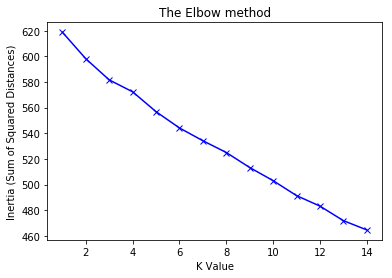

In [26]:
plt.plot(K, inertia, 'bx-')
plt.xlabel('K Value')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.title('The Elbow method')
plt.show()

In [27]:
silhouette = []
K = np.arange(2, 16)

for k in K:
    kmean = KMeans(n_clusters=k, random_state=1)
    labels_pred = kmean.fit_predict(sp_venues_grouped_scaled)    
    silhouette.append(silhouette_score(sp_venues_grouped_scaled, labels_pred))

Text(0, 0.5, 'Silhouette score')

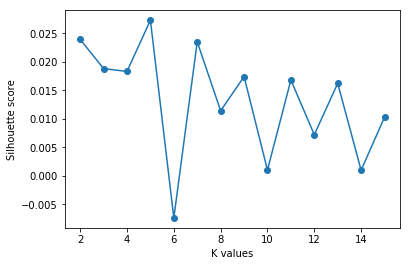

In [28]:
#As shown on the plot, the optimal value is 6 for K
plt.plot(K, silhouette, 'o-')
plt.xlabel('K values')
plt.ylabel('Silhouette score')

## Running the KMeans algorithm with the optimal value of 6 clusters

In [29]:
k = 6
kmeans = KMeans(n_clusters=k, random_state=1)
labels = kmeans.fit_predict(sp_venues_grouped_scaled)

In [30]:
stations_venues_sorted.insert(0, 'Clusters labels', labels)

In [31]:
metros.columns = ['Stations', 'Latitude', 'Longitude', 'Line', 'Neighborhood']

In [32]:
clusters_merged = metros.join(stations_venues_sorted.set_index('Stations'), on='Stations')

In [33]:
clusters_merged

,Stations,Latitude,Longitude,Line,Neighborhood,Clusters labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Aacd Servidor,-23.597825,-46.652374,['lilas'],"['moema', 'hospital-sao-paulo']",4,Restaurant,Brazilian Restaurant,Café,Athletics & Sports,Hotel,Bakery,Coffee Shop,Bar,Residential Building (Apartment / Condo),Churrascaria
1,Adolfo Pinheiro,-23.650073,-46.704206,['lilas'],"['largo-treze', 'alto-da-boa-vista']",5,Clothing Store,Arts & Crafts Store,Farmers Market,Cosmetics Shop,Restaurant,Chocolate Shop,Theater,Rental Car Location,Beer Bar,Middle Eastern Restaurant
2,Alto Da Boa Vista,-23.641625,-46.699434,['lilas'],"['adolfo-pinheiro', 'borba-gato']",5,Plaza,Pharmacy,Gym / Fitness Center,Pizza Place,Coffee Shop,Pet Store,Farmers Market,Gym Pool,Restaurant,Chinese Restaurant
3,Alto Do Ipiranga,-23.602237,-46.612486,['verde'],"['santos-imigrantes', 'sacoma']",1,Burger Joint,Pharmacy,Dessert Shop,Gym,Pizza Place,Brazilian Restaurant,Convenience Store,Bar,Gym Pool,Restaurant
4,Ana Rosa,-23.581871,-46.638104,"['azul', 'verde']","['paraiso', 'vila-mariana', 'paraiso', 'chacar...",4,Dessert Shop,Café,Brazilian Restaurant,Bar,Ice Cream Shop,Bakery,Japanese Restaurant,Vegetarian / Vegan Restaurant,Hostel,Martial Arts Dojo
5,Anhangabau,-23.547825,-46.639180,['vermelha'],"['se', 'republica']",4,Café,Brazilian Restaurant,Restaurant,Coffee Shop,Theater,Bookstore,Vegetarian / Vegan Restaurant,Bar,Bakery,Cultural Center
6,Armenia,-23.525410,-46.629259,['azul'],"['portuguesa-tiete', 'tiradentes']",4,Brazilian Restaurant,Café,History Museum,Dessert Shop,Athletics & Sports,Noodle House,Mineiro Restaurant,Snack Place,Bakery,Music Venue
7,Artur Alvim,-23.540244,-46.484706,['vermelha'],"['corinthians-itaquera', 'patriarca-vila-re']",1,Pizza Place,Department Store,Sports Bar,Pharmacy,Gymnastics Gym,Bar,Brazilian Restaurant,Cosmetics Shop,Gym / Fitness Center,Pet Store
8,Belem,-23.542872,-46.589615,['vermelha'],"['tatuape', 'bresser-mooca']",0,Restaurant,Brazilian Restaurant,Bar,Pizza Place,Café,Snack Place,Fast Food Restaurant,Burger Joint,Plaza,Pet Store
9,Borba Gato,-23.633466,-46.692867,['lilas'],"['alto-da-boa-vista', 'brooklin']",4,Brazilian Restaurant,Bar,Farmers Market,Pharmacy,Restaurant,Supermarket,Tennis Court,Sandwich Place,Gift Shop,Gym


## Let's visualize the clusters

In [34]:
import matplotlib.cm as cm
import matplotlib.colors as colors

In [35]:
map_clusters = folium.Map([latitude, longitude], zoom_start=10)

#color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

#add markers to the map
markers_colors = []
for lat, lon, name, cluster in zip(clusters_merged['Latitude'], clusters_merged['Longitude'], clusters_merged['Stations'], clusters_merged['Clusters labels']):
    label = folium.Popup(str(name) + 'Cluster' + str(cluster), parse_html=True)
    folium.CircleMarker([lat, lon],
                       radius=5,
                       popup=label,
                       color=rainbow[cluster-1],
                       fill=True,
                       fill_color=rainbow[cluster-1],
                       fill_opacity=0.7).add_to(map_clusters)

map_clusters    

## Examine the clusters

### Cluster 0

In [36]:
cluster_0 = clusters_merged[clusters_merged['Clusters labels'] == 0]
cluster_0

,Stations,Latitude,Longitude,Line,Neighborhood,Clusters labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Belem,-23.542872,-46.589615,['vermelha'],"['tatuape', 'bresser-mooca']",0,Restaurant,Brazilian Restaurant,Bar,Pizza Place,Café,Snack Place,Fast Food Restaurant,Burger Joint,Plaza,Pet Store
28,Giovanni Gronchi,-23.643930,-46.733983,['lilas'],"['vila-das-belezas', 'santo-amaro']",0,Fast Food Restaurant,Brazilian Restaurant,Breakfast Spot,Gym / Fitness Center,Bakery,Snack Place,Salad Place,Paintball Field,Restaurant,Motel
75,Vila Matilde,-23.531917,-46.530873,['vermelha'],"['guilhermina-esperanca', 'penha']",0,Pizza Place,Athletics & Sports,Department Store,Restaurant,Motel,Brazilian Restaurant,Middle Eastern Restaurant,Gym,Beer Garden,Bar
76,Vila Prudente,-23.584595,-46.583437,"['prata', 'verde']","['oratorio', 'tamanduatei']",0,Snack Place,Diner,Food Truck,Gym / Fitness Center,Pharmacy,Brazilian Restaurant,Plaza,Pet Store,Grocery Store,Supermarket


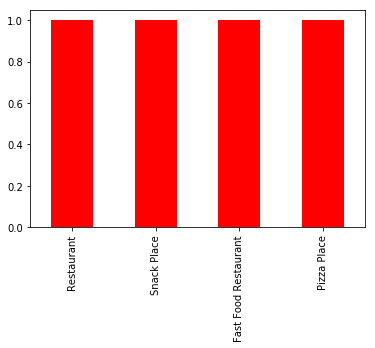

In [37]:
#1st Most Common Venue bar plot
cluster_0['1st Most Common Venue'].value_counts().plot.bar(color='r')

### Cluster 1

In [38]:
cluster_1 = clusters_merged[clusters_merged['Clusters labels'] == 1]
cluster_1

,Stations,Latitude,Longitude,Line,Neighborhood,Clusters labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Alto Do Ipiranga,-23.602237,-46.612486,['verde'],"['santos-imigrantes', 'sacoma']",1,Burger Joint,Pharmacy,Dessert Shop,Gym,Pizza Place,Brazilian Restaurant,Convenience Store,Bar,Gym Pool,Restaurant
7,Artur Alvim,-23.540244,-46.484706,['vermelha'],"['corinthians-itaquera', 'patriarca-vila-re']",1,Pizza Place,Department Store,Sports Bar,Pharmacy,Gymnastics Gym,Bar,Brazilian Restaurant,Cosmetics Shop,Gym / Fitness Center,Pet Store
10,Bras,-23.545326,-46.616444,['vermelha'],"['bresser-mooca', 'pedro-ii']",1,Brazilian Restaurant,Burger Joint,Clothing Store,Plaza,Sandwich Place,Buffet,Dessert Shop,Furniture / Home Store,Gaming Cafe,Café
11,Bresser Mooca,-23.546361,-46.607152,['vermelha'],"['belem', 'bras']",1,Diner,Bar,Hardware Store,Gym,Café,Outlet Store,Fast Food Restaurant,Bakery,Lawyer,Restaurant
13,Brooklin,-23.626802,-46.688128,['lilas'],"['borba-gato', 'eucaliptos']",1,Bakery,Gym,Burger Joint,Bar,Café,Pharmacy,Motorcycle Shop,Salon / Barbershop,Supermarket,Brazilian Restaurant
15,Camilo Haddad,-23.595517,-46.537590,['prata'],"['sao-lucas', 'vila-tolstoi']",1,Farmers Market,Dessert Shop,Gym / Fitness Center,Plaza,Bakery,Pizza Place,Flea Market,Food Truck,Convenience Store,Fondue Restaurant
16,Campo Limpo,-23.649246,-46.758930,['lilas'],"['capao-redondo', 'vila-das-belezas']",1,Mobile Phone Shop,Market,Fast Food Restaurant,Clothing Store,Pet Store,Fried Chicken Joint,Shoe Store,Bus Station,Bakery,Gym
17,Capao Redondo,-23.659169,-46.768001,['lilas'],['campo-limpo'],1,Brazilian Restaurant,Gym / Fitness Center,Grocery Store,Bakery,Health Food Store,Furniture / Home Store,Bus Station,Burger Joint,Diner,Bridal Shop
24,Corinthians Itaquera,-23.542299,-46.471207,['vermelha'],['artur-alvim'],1,Clothing Store,Fried Chicken Joint,Burger Joint,Coffee Shop,Italian Restaurant,Chocolate Shop,Café,Ice Cream Shop,Bookstore,Brazilian Restaurant
29,Guilhermina Esperanca,-23.529305,-46.516640,['vermelha'],"['patriarca-vila-re', 'vila-matilde']",1,Bus Station,Restaurant,Plaza,Diner,Metro Station,Pastelaria,Mobile Phone Shop,Supermarket,Grocery Store,Gym


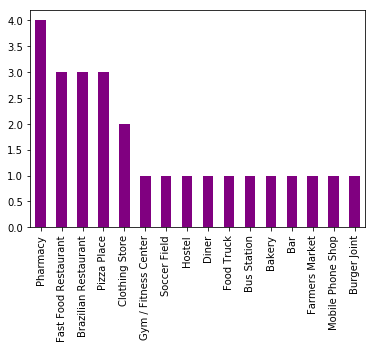

In [39]:
cluster_1['1st Most Common Venue'].value_counts().plot.bar(color='purple')

### Cluster 2

In [40]:
cluster_2 = clusters_merged[clusters_merged['Clusters labels'] == 2]
cluster_2

,Stations,Latitude,Longitude,Line,Neighborhood,Clusters labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
33,Japao Liberdade,-23.555177,-46.635602,['azul'],"['se', 'sao-joaquim']",2,Japanese Restaurant,Sake Bar,Grocery Store,Cosmetics Shop,Nightclub,Bakery,Coffee Shop,Theater,Chinese Restaurant,Sushi Restaurant
50,Praca Da Arvore,-23.610505,-46.637919,['azul'],"['santa-cruz', 'saude']",2,Dessert Shop,Japanese Restaurant,Cosmetics Shop,Dance Studio,Plaza,Martial Arts Dojo,Gastropub,Steakhouse,Brazilian Restaurant,Brewery
60,Sao Joaquim,-23.561367,-46.638601,['azul'],"['japao-liberdade', 'vergueiro']",2,Japanese Restaurant,Bar,Ramen Restaurant,Sake Bar,Theater,Bakery,Café,Sushi Restaurant,Brazilian Restaurant,Martial Arts Dojo
64,Saude,-23.618246,-46.639190,['azul'],"['praca-da-arvore', 'sao-judas']",2,Pharmacy,Restaurant,Martial Arts Dojo,Bakery,Vegetarian / Vegan Restaurant,Brazilian Restaurant,Gym / Fitness Center,Japanese Restaurant,Café,Pet Store


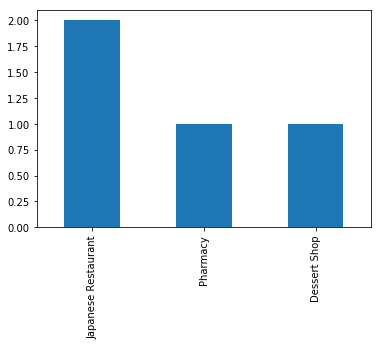

In [41]:
cluster_2['1st Most Common Venue'].value_counts().plot.bar()

### Cluster 3

In [42]:
cluster_3 = clusters_merged[clusters_merged['Clusters labels'] == 3]
cluster_3

,Stations,Latitude,Longitude,Line,Neighborhood,Clusters labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
23,Consolacao,-23.558121,-46.660219,['verde'],"['clinicas', 'trianon-masp']",3,Brazilian Restaurant,Coffee Shop,Café,Hotel,Vegetarian / Vegan Restaurant,Movie Theater,Bar,Gym / Fitness Center,Gym,Theater
45,Paulista,-23.555246,-46.662268,['amarela'],"['oscar-freire', 'higienopolis-mackenzie']",3,Brazilian Restaurant,Vegetarian / Vegan Restaurant,Café,Gym / Fitness Center,Burger Joint,Comic Shop,Hotel,Cosmetics Shop,Ice Cream Shop,Gym


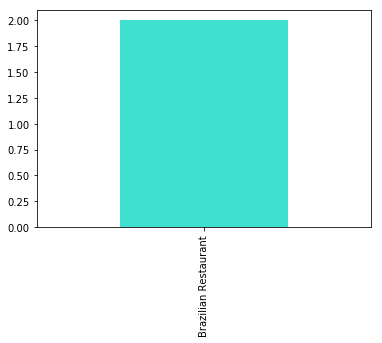

In [43]:
cluster_3['1st Most Common Venue'].value_counts().plot.bar(color='turquoise')

### Cluster 4

In [44]:
cluster_4 = clusters_merged[clusters_merged['Clusters labels'] == 4]
cluster_4

,Stations,Latitude,Longitude,Line,Neighborhood,Clusters labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Aacd Servidor,-23.597825,-46.652374,['lilas'],"['moema', 'hospital-sao-paulo']",4,Restaurant,Brazilian Restaurant,Café,Athletics & Sports,Hotel,Bakery,Coffee Shop,Bar,Residential Building (Apartment / Condo),Churrascaria
4,Ana Rosa,-23.581871,-46.638104,"['azul', 'verde']","['paraiso', 'vila-mariana', 'paraiso', 'chacar...",4,Dessert Shop,Café,Brazilian Restaurant,Bar,Ice Cream Shop,Bakery,Japanese Restaurant,Vegetarian / Vegan Restaurant,Hostel,Martial Arts Dojo
5,Anhangabau,-23.547825,-46.639180,['vermelha'],"['se', 'republica']",4,Café,Brazilian Restaurant,Restaurant,Coffee Shop,Theater,Bookstore,Vegetarian / Vegan Restaurant,Bar,Bakery,Cultural Center
6,Armenia,-23.525410,-46.629259,['azul'],"['portuguesa-tiete', 'tiradentes']",4,Brazilian Restaurant,Café,History Museum,Dessert Shop,Athletics & Sports,Noodle House,Mineiro Restaurant,Snack Place,Bakery,Music Venue
9,Borba Gato,-23.633466,-46.692867,['lilas'],"['alto-da-boa-vista', 'brooklin']",4,Brazilian Restaurant,Bar,Farmers Market,Pharmacy,Restaurant,Supermarket,Tennis Court,Sandwich Place,Gift Shop,Gym
12,Brigadeiro,-23.567728,-46.648937,['verde'],"['trianon-masp', 'paraiso']",4,Coffee Shop,Japanese Restaurant,Hotel,Sushi Restaurant,Health & Beauty Service,Middle Eastern Restaurant,Pizza Place,Cosmetics Shop,Convenience Store,Candy Store
19,Carrao,-23.537887,-46.564262,['vermelha'],"['penha', 'tatuape']",4,Farmers Market,Pizza Place,Café,Bike Rental / Bike Share,Park,Bar,Gym,Bakery,Soccer Stadium,Men's Store
21,Clinicas,-23.554112,-46.673005,['verde'],"['santuario-nossa-senhora-de-fatima-sumare', '...",4,Café,Coffee Shop,Brazilian Restaurant,Flower Shop,Restaurant,Gym / Fitness Center,Bus Stop,Gymnastics Gym,Park,Skate Park
22,Conceicao,-23.635011,-46.641295,['azul'],"['sao-judas', 'jabaquara']",4,Brazilian Restaurant,Café,Japanese Restaurant,Tea Room,Restaurant,Pizza Place,Bakery,Pharmacy,Chocolate Shop,Salad Place
26,Faria Lima,-23.567255,-46.693959,['amarela'],"['pinheiros', 'fradique-coutinho']",4,Brazilian Restaurant,Restaurant,Coffee Shop,Italian Restaurant,Vegetarian / Vegan Restaurant,Bakery,Health Food Store,Bar,Salon / Barbershop,Asian Restaurant


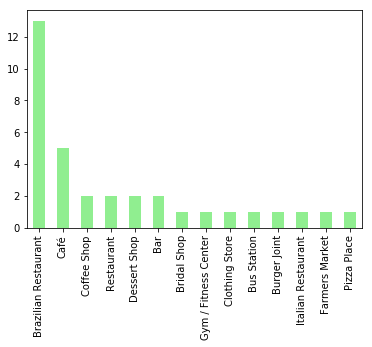

In [45]:
cluster_4['1st Most Common Venue'].value_counts().plot.bar(color='lightgreen')

### Cluster 5

In [46]:
cluster_5 = clusters_merged[clusters_merged['Clusters labels'] == 5]
cluster_5

,Stations,Latitude,Longitude,Line,Neighborhood,Clusters labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Adolfo Pinheiro,-23.650073,-46.704206,['lilas'],"['largo-treze', 'alto-da-boa-vista']",5,Clothing Store,Arts & Crafts Store,Farmers Market,Cosmetics Shop,Restaurant,Chocolate Shop,Theater,Rental Car Location,Beer Bar,Middle Eastern Restaurant
2,Alto Da Boa Vista,-23.641625,-46.699434,['lilas'],"['adolfo-pinheiro', 'borba-gato']",5,Plaza,Pharmacy,Gym / Fitness Center,Pizza Place,Coffee Shop,Pet Store,Farmers Market,Gym Pool,Restaurant,Chinese Restaurant
14,Butanta,-23.571900,-46.708090,['amarela'],"['sao-paulo-morumbi', 'pinheiros']",5,Restaurant,Brazilian Restaurant,Plaza,Bar,Pizza Place,Martial Arts Dojo,Coffee Shop,Bakery,Burger Joint,Buffet
18,Carandiru,-23.509547,-46.624977,['azul'],"['santana', 'portuguesa-tiete']",5,Furniture / Home Store,Brazilian Restaurant,Plaza,Electronics Store,Restaurant,Bar,Café,Hotel,Pharmacy,Bowling Alley
20,Chacara Klabin,-23.592681,-46.630681,"['lilas', 'verde']","['santa-cruz', 'ana-rosa', 'santos-imigrantes']",5,Pizza Place,Burger Joint,Gym / Fitness Center,Café,Pet Store,Dog Run,Plaza,Spa,Sushi Restaurant,Gym
25,Eucaliptos,-23.609795,-46.668617,['lilas'],"['brooklin', 'moema']",5,Shoe Store,Cosmetics Shop,Women's Store,Clothing Store,Ice Cream Shop,Burger Joint,Brazilian Restaurant,Spa,Gym / Fitness Center,Electronics Store
44,Patriarca Vila Re,-23.531144,-46.503638,['vermelha'],"['artur-alvim', 'guilhermina-esperanca']",5,Pizza Place,Gym / Fitness Center,Bar,Food,Cosmetics Shop,Grocery Store,Farmers Market,Music Venue,Sushi Restaurant,Bakery
56,Santo Amaro,-23.656230,-46.719116,['lilas'],"['giovanni-gronchi', 'largo-treze']",5,Restaurant,Metro Station,Japanese Restaurant,Bus Station,Pet Store,Outdoors & Recreation,Tea Room,Sandwich Place,Brazilian Restaurant,Train Station
74,Vila Mariana,-23.589178,-46.634668,['azul'],"['ana-rosa', 'santa-cruz']",5,Gym / Fitness Center,Pizza Place,Pet Store,Hostel,Paper / Office Supplies Store,Brazilian Restaurant,Coffee Shop,Cosmetics Shop,Pharmacy,Bar


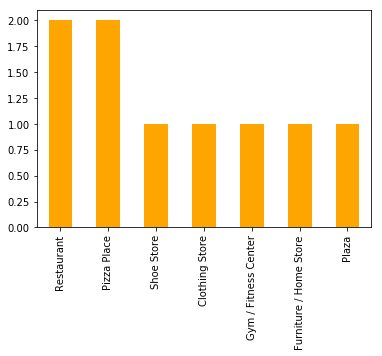

In [47]:
cluster_5['1st Most Common Venue'].value_counts().plot.bar(color='orange')

## Results and Discussion <a name="results"></a>

### Results
As we can see from the bar plots there are lots of food venues near São Paulo’s subway stations, we can see that cluster 1 has the high concentration of japanese restaurants, so at first this shows that those subway stations have a high competition to our venue. With only the data provided by Foursquare API we can not make a decision, but we can argue that cluster 1 has 3 stations near of the largest japanese neighborhood in São Paulo (Liberdade, Praça da Árvore and São Joaquim), so we would have high number of clients. Using more data about those places we can refine our choice.


### Discussion
The cluster 1 has a high number of japanese restaurants, so at first is advisable work with the data about cluster’s 1 stations, inspec the restaurants location’s is a good start point.


## Conclusion <a name="conclusion"></a>

The cluster 1 has a high number of japanese restaurants, so at first is advisable work with the data about cluster’s 1 stations, inspec the restaurants location’s is a good start point.
